# Uber Fare Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

## Data Exploration and Cleaning

In [2]:
# Read the data
data = pd.read_csv('uber_fare_prediction.csv')

# Display the first 5 rows of the DataFrame
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# Get the summary information of the data
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


<Axes: xlabel='fare_amount', ylabel='Count'>

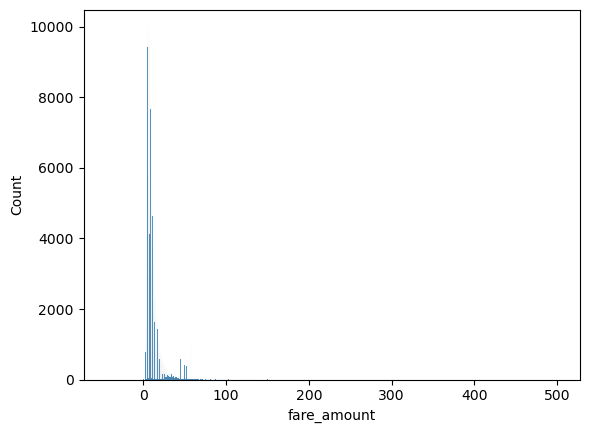

In [4]:
# Plot a histogram of the 'fare_amount' column
sns.histplot(data, x="fare_amount")

<Axes: xlabel='passenger_count', ylabel='Count'>

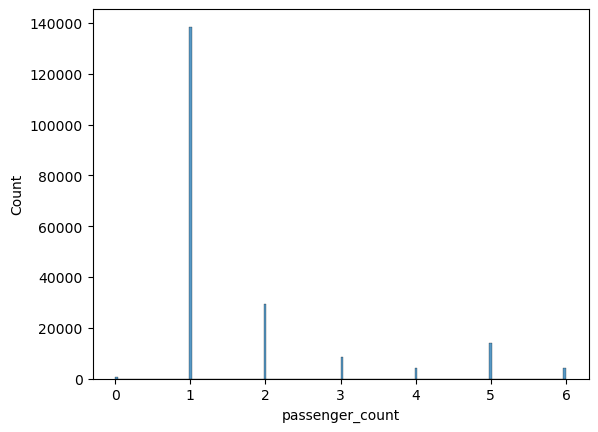

In [5]:
# Plot a histogram of the 'passenger_count' column
sns.histplot(data, x="passenger_count")

In [6]:
# Check the number of missing values in each column
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
# Define columns to check for non-zero values
columns_to_check = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

# Create a mask to filter out rows with all zero values in the specified columns
mask = (data[columns_to_check] != 0).all(axis=1)

# Apply the mask to create a new DataFrame without rows with all zero values
cleaned_df = data[mask]
cleaned_df.reset_index(drop=True, inplace=True)

In [8]:
# Check for missing values in 'dropoff_longitude' or 'dropoff_latitude'
cleaned_df[(cleaned_df['dropoff_longitude'].isnull()) | (cleaned_df['dropoff_latitude'].isnull())]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
117801,57:00.0,12.5,2012-12-11 12:57:00 UTC,-73.99276,40.743098,NaN,NaN,0


In [9]:
# Drop rows with missing values in 'dropoff_longitude' or 'dropoff_latitude'
cleaned_df = cleaned_df.dropna(subset=['dropoff_longitude', 'dropoff_latitude'])

In [10]:
# Get summary statistics of the cleaned DataFrame
cleaned_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,196049.000000,196049.000000,196049.000000,196049.000000,196049.000000,196049.000000
mean,11.329400,-73.903194,40.703912,-73.914510,40.691373,1.682875
std,9.761749,5.841408,4.582677,3.749474,3.912035,1.306990
min,-44.900000,-736.550000,-74.007670,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992258,40.736588,-73.991470,40.735605,1.000000
50%,8.500000,-73.982038,40.753500,-73.980490,40.753929,1.000000
75%,12.500000,-73.968273,40.767532,-73.965118,40.768375,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [11]:
# Define ranges for valid longitude and latitude values
dropoff_longitude_range = (-75, 41)
dropoff_latitude_range = (-75, 42)
pickup_longitude_range = (-75, 41)
pickup_latitude_range = (-75, 42)

# Define invalid values
invalid_values = [-0.004093, 0.0335, 0.016852, -7.98664, 0.01798, 0.728087]

# Create masks for filtering out invalid values
mask_dropoff_longitude = (cleaned_df['dropoff_longitude'] >= dropoff_longitude_range[0]) & \
                            (cleaned_df['dropoff_longitude'] <= dropoff_longitude_range[1]) & \
                            (~cleaned_df['dropoff_longitude'].isin(invalid_values))

mask_dropoff_latitude = (cleaned_df['dropoff_latitude'] >= dropoff_latitude_range[0]) & \
                        (cleaned_df['dropoff_latitude'] <= dropoff_latitude_range[1]) & \
                        (~cleaned_df['dropoff_latitude'].isin(invalid_values))

mask_pickup_longitude = (cleaned_df['pickup_longitude'] >= pickup_longitude_range[0]) & \
                        (cleaned_df['pickup_longitude'] <= pickup_longitude_range[1]) & \
                        (~cleaned_df['pickup_longitude'].isin(invalid_values))

mask_pickup_latitude = (cleaned_df['pickup_latitude'] >= pickup_latitude_range[0]) & \
                        (cleaned_df['pickup_latitude'] <= pickup_latitude_range[1]) & \
                        (~cleaned_df['pickup_latitude'].isin(invalid_values))

# Combine masks to create a final mask
final_mask = mask_dropoff_longitude & mask_dropoff_latitude & mask_pickup_longitude & mask_pickup_latitude

# Apply the final mask to the DataFrame
cleaned_df = cleaned_df[final_mask]
cleaned_df.reset_index(drop=True, inplace=True)

In [12]:
# Get summary statistics of the cleaned DataFrame
cleaned_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000
mean,11.328184,-73.911385,40.693631,-73.909110,40.694566,1.682893
std,9.760290,2.615471,2.496059,2.634223,2.491719,1.307024
min,-44.900000,-74.968142,-74.007670,-74.960020,-74.035197,0.000000
25%,6.000000,-73.992255,40.736590,-73.991470,40.735607,1.000000
50%,8.500000,-73.982037,40.753500,-73.980490,40.753929,1.000000
75%,12.500000,-73.968272,40.767531,-73.965118,40.768374,2.000000
max,500.000000,40.811147,41.800252,40.851027,41.923820,6.000000


## Feature Engineering

In [13]:
# Apply winsorization to the 'fare_amount' column to limit extreme values and create a new column 'fare_amount_win'
cleaned_df['fare_amount_win'] = stats.mstats.winsorize(cleaned_df['fare_amount'], limits=[0.01, 0.01])

# Display the first 15 rows of the DataFrame
cleaned_df.head(15)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_win
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,4.5
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,16.9
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,5.7
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,7.7
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,5.3
5,50:45.0,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,12.1
6,35:00.0,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,7.5
7,22:00.0,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,16.5
8,10:00.0,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,9.0
9,11:00.0,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,8.9


In [14]:
# Convert the pickup_datetime column to datetime
cleaned_df['pickup_datetime'] = pd.to_datetime(cleaned_df['pickup_datetime'] )

# Extract the year, month, and day from the 'pickup_datetime' column
cleaned_df['year'] = cleaned_df['pickup_datetime'].dt.year
cleaned_df['month'] = cleaned_df['pickup_datetime'].dt.month
cleaned_df['day'] = cleaned_df['pickup_datetime'].dt.day

# Extract the hour of the day (hour 0-23)
cleaned_df['hour'] = cleaned_df['pickup_datetime'].dt.hour

# Extract the day of the week (weekday1-7)
cleaned_df['weekday'] = cleaned_df['pickup_datetime'].dt.dayofweek + 1  

In [15]:
# Display the first 5 rows of the newly created columns
cleaned_df[['pickup_datetime', 'year', 'month', 'day', 'hour', 'weekday']].head()

,pickup_datetime,year,month,day,hour,weekday
0,2009-06-15 17:26:21+00:00,2009,6,15,17,1
1,2010-01-05 16:52:16+00:00,2010,1,5,16,2
2,2011-08-18 00:35:00+00:00,2011,8,18,0,4
3,2012-04-21 04:30:42+00:00,2012,4,21,4,6
4,2010-03-09 07:51:00+00:00,2010,3,9,7,2


In [16]:
# Drop the 'key' column from the DataFrame as it is no longer needed
cleaned_df.drop(columns = ['key'], inplace=True)

In [17]:
# Define a function to calculate the Haversine distance between two points
def haversine_distance(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1 # Longitude difference
    dlat = lat2 - lat1 # Latitude difference
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of the Earth in kilometers
    distance = c * r
    
    return distance

# Apply the haversine_distance function to each row of the DataFrame to calculate the distance
cleaned_df['distance'] = cleaned_df.apply(lambda row: haversine_distance(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Display the first 5 rows of the DataFrame including the calculated distance
cleaned_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,-73.844311,40.721319,-73.841610,40.712278,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1.999157


In [18]:
# Get summary statistics of the cleaned DataFrame
cleaned_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_win,year,month,day,hour,weekday,distance
count,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000,196019.000000
mean,11.328184,-73.911385,40.693631,-73.909110,40.694566,1.682893,11.214793,2011.738668,6.272055,15.684046,13.518516,4.038874,4.076823
std,9.760290,2.615471,2.496059,2.634223,2.491719,1.307024,8.937939,1.864215,3.444767,8.672666,6.502501,1.949230,63.583748
min,-44.900000,-74.968142,-74.007670,-74.960020,-74.035197,0.000000,3.300000,2009.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,6.000000,-73.992255,40.736590,-73.991470,40.735607,1.000000,6.000000,2010.000000,3.000000,8.000000,9.000000,2.000000,1.255971
50%,8.500000,-73.982037,40.753500,-73.980490,40.753929,1.000000,8.500000,2012.000000,6.000000,16.000000,14.000000,4.000000,2.154590
75%,12.500000,-73.968272,40.767531,-73.965118,40.768374,2.000000,12.500000,2013.000000,9.000000,23.000000,19.000000,6.000000,3.909372
max,500.000000,40.811147,41.800252,40.851027,41.923820,6.000000,52.000000,2015.000000,12.000000,31.000000,23.000000,7.000000,6027.225438


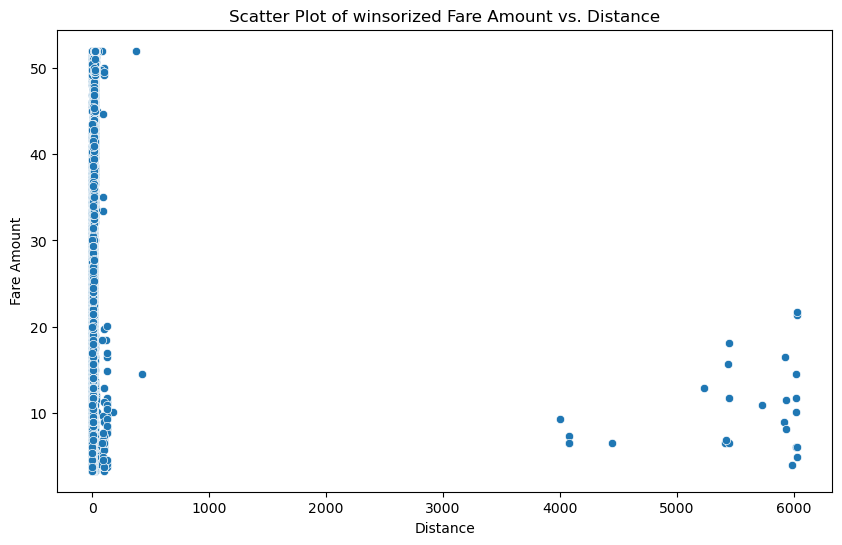

In [19]:
# Create a scatter plot of fare amount vs. distance
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(data=cleaned_df, x='distance', y='fare_amount_win')

# Add a title and labels
plt.title('Scatter Plot of winsorized Fare Amount vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Fare Amount')

# Display the plot
plt.show()

In [20]:
# Apply winsorization to the 'distance' column to limit extreme values and create a new column 'distance_win'
cleaned_df['distance_win'] = stats.mstats.winsorize(cleaned_df['distance'], limits=[0.01, 0.01])

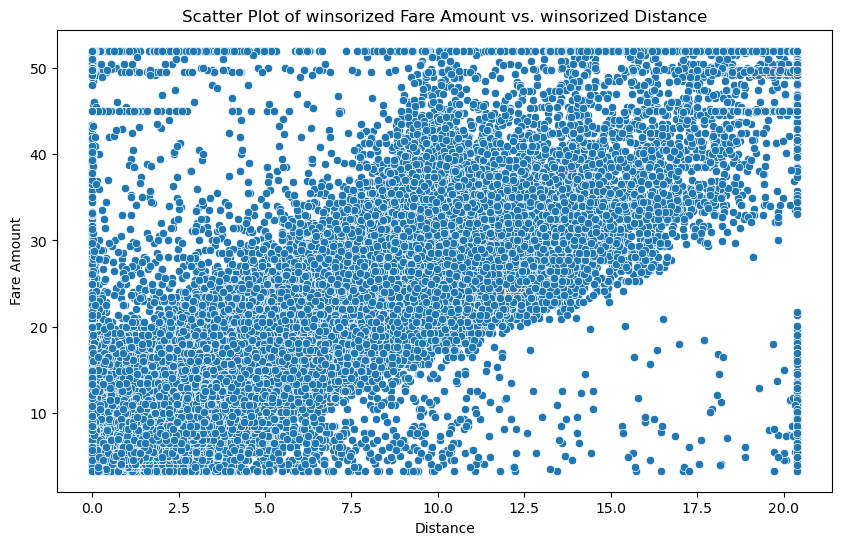

In [21]:
# Create a scatter plot of fare amount vs. distance with winsorized values
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='distance_win', y='fare_amount_win')

# Add a title and labels
plt.title('Scatter Plot of winsorized Fare Amount vs. winsorized Distance')
plt.xlabel('Distance')
plt.ylabel('Fare Amount')

# Display the plot
plt.show()

In [22]:
# Calculate the correlation matrix for the selected features and the winsorized fare amount
cleaned_df[['passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'distance_win', 'fare_amount_win']].corr()

,passenger_count,year,month,day,hour,weekday,distance_win,fare_amount_win
passenger_count,1.000000,0.007782,0.005048,0.007118,0.015915,0.036723,0.013243,0.016440
year,0.007782,1.000000,-0.118480,-0.009656,0.003263,0.011424,0.024578,0.119175
month,0.005048,-0.118480,1.000000,-0.020533,-0.002992,-0.008389,0.011253,0.024420
day,0.007118,-0.009656,-0.020533,1.000000,0.002628,0.008272,0.001173,-0.000008
hour,0.015915,0.003263,-0.002992,0.002628,1.000000,-0.089959,-0.031299,-0.018972
weekday,0.036723,0.011424,-0.008389,0.008272,-0.089959,1.000000,0.015503,0.003116
distance_win,0.013243,0.024578,0.011253,0.001173,-0.031299,0.015503,1.000000,0.875707
fare_amount_win,0.016440,0.119175,0.024420,-0.000008,-0.018972,0.003116,0.875707,1.000000


## Model selection, Training, Evaluation, and Prediction

### a regression model for numeric response (fare_amount_win)

In [23]:
# Define the predictors and the response.
X = cleaned_df[['passenger_count', 'year', 'month', 'hour', 'distance_win']]
y = cleaned_df.fare_amount_win

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77)

In [25]:
# Define the number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=77)

# Initialize an array to store the RMSE values for each fold
rmse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model1 = LinearRegression()
    
    # Fit the model on the training data
    model1.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model1.predict(X_test)
    
    # Calculate the RMSE for this fold and append it to the list of RMSE scores
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
print(f"Linear Regression with cross-validation: RMSE: {np.mean(rmse_scores)}")

Linear Regression with cross-validation: RMSE: 4.218980496466271


In [26]:
# Define the models to be compared
models = [
    ("Lasso", Lasso(alpha=1.0)),
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=77)),
    ("Random Forest Regressor", RandomForestRegressor(random_state=77)),
    ("K-Nearest Neighbors Regressor", KNeighborsRegressor(n_neighbors=5))
]

# Train and evaluate each model
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE for this model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE: {rmse}")

Lasso: RMSE: 4.287761159100726
Decision Tree Regressor: RMSE: 5.489407196307616
Random Forest Regressor: RMSE: 4.072017430653783
K-Nearest Neighbors Regressor: RMSE: 4.2342146010154575


In [27]:
# Define the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=77)

# Train and evaluate the model
gbr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gbr = gbr_model.predict(X_test)

# Calculate the RMSE for this model
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)
print(f"Gradient Boosting Regressor: RMSE: {rmse}")

Gradient Boosting Regressor: RMSE: 3.8303543062042373


Text(0.5, 1.0, 'Feature Importance')

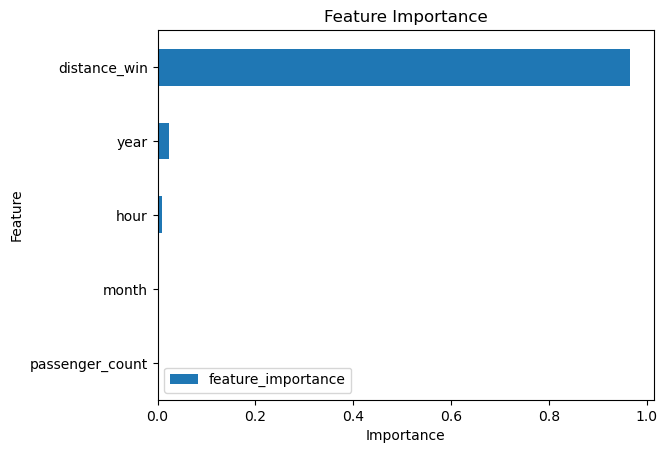

In [28]:
# Create a DataFrame to display feature importances, sorted by importance value
plot_to_show = pd.DataFrame(gbr_model.feature_importances_, columns=['feature_importance'], index=X_train.columns).sort_values(['feature_importance'])

# Plot feature importances as a horizontal bar chart
plot_to_show.plot(kind='barh')

# Add a title and labels
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

In [29]:
# Display feature importances with specific values
plot_to_show.sort_values(['feature_importance'], ascending=False)

,feature_importance
distance_win,0.965359
year,0.024124
hour,0.008614
month,0.001792
passenger_count,0.000111


In [30]:
# Save predictions to a DataFrame
predictions_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_gbr})

# Save predictions to a CSV file
predictions_df.to_csv("gradient_boosting_predictions.csv", index=False)